In [1]:
import os
from utils.core.config import initialize_daanish, load_project_config
from utils.data_io import load_data
from utils.core.feature_manager import FeatureManager
from utils.eda.descriptive import DescriptiveAnalysis
from utils.viz.display import DisplayUtils
from utils.core.save_manager import SaveUtils
from utils.core.format_utils import FormatUtils
from utils.eda.statistical import StatisticalAnalysis
from utils.eda.visualisation import Visualisation
from utils.eda.correlation import CorrelationAnalyzer
import pandas as pd
from utils.preprocessing.missing_values import MissingValueHandler
from utils.features.selector import FeatureSelector
from utils.eda.outlier_detection import OutlierDetector
from utils.preprocessing.outlier_treatment import OutlierHandler
from utils.eda.multicollinearity import MulticollinearityDetector
from utils.eda.pca_analyzer import PCAAnalyzer
from utils.eda.mca_analyzer import MCAAnalyzer


#### Step 1: Project Initialization and Data Loading 
In this step, we:
- Initialize the Daanish core setup
- Access global and project-specific configuration values
- Construct input and output paths based on project settings
- Load the main dataset for modeling
- Load the list of model features along with their attributes

- Initialize the Daanish core setup

In [2]:
global_config = initialize_daanish()


Daanish core setup complete.


- Access global and project-specific configuration values

In [3]:

project_root = os.getcwd()
project_config = load_project_config(project_root)

input_data_folder = project_config.get('paths', 'input_data_folder')
output_data_folder = project_config.get('paths', 'output_data_folder')
main_dataset = project_config.get('input_files', 'main_dataset')
model_features = project_config.get('input_files', 'features_attributes')
source_type = project_config.get('datasource_type', 'source_type')
main_dataset_query = project_config.get('db_queries', 'main_dataset_query')
model_features_query = project_config.get('db_queries', 'model_features_query')

INFO:utils.core.config:Loading project configuration from c:\Data Science Projects\Daanish\projects\probability_of_default\project_config.ini
INFO:utils.core.config:Project configuration loaded successfully


- Construct input and output paths based on project settings

In [4]:

input_path = os.path.join(project_root, input_data_folder)
output_path = os.path.join(project_root, output_data_folder)

- Load the main dataset for modeling

In [5]:
main_df = load_data(
    source_type=source_type,
    input_path=os.path.join(input_path, main_dataset),
    query=main_dataset_query,
    global_config=global_config
)

- Load the list of model features along with their attributes

In [6]:
feature_manager = FeatureManager(
    source_type=source_type,
    input_path=os.path.join(input_path, model_features),
    global_config=global_config,
    query=model_features_query
)

# Feature types
nominal_features = feature_manager.get_nominal_features()
ordinal_features = feature_manager.get_ordinal_features()
numerical_features = feature_manager.get_numerical_features()
target_variable = feature_manager.get_target_variable()
all_features = feature_manager.get_all_features()

# Missing value handling
missing_value_strategies = feature_manager.get_missing_value_strategies()
missing_fill_values = feature_manager.get_missing_fill_values()

# Display names
display_names = feature_manager.get_display_names()

# Outlier handling configs
outlier_strategies = feature_manager.get_outlier_detection_strategies()
outlier_params = feature_manager.get_outlier_detection_params()
outlier_imputation_methods = feature_manager.get_outlier_imputation_methods()
outlier_imputation_values = feature_manager.get_outlier_imputation_values()
outlier_config_bundle = feature_manager.get_outlier_config_bundle()

# print("Nominal Features:", nominal_features)
# print("Ordinal Features:", ordinal_features)
# print("Numerical Features:", numerical_features)
# print("Target Variable:", target_variable)
# print("All Features:", all_features)
# print("Missing Value Strategies:", missing_value_strategies)
# print("Missing Fill Values:", missing_fill_values)
# print("Display Names:", display_names)

#### Step 2: Preliminary Exploratory Data Analysis (EDA)

In this step, we explore the raw dataset to understand its structure, identify potential issues (e.g., missing values, outliers, inconsistent types), and gain initial insights into data distributions. This provides the foundation for informed preprocessing and feature engineering decisions later.

In [7]:
# initializing the `DescriptiveAnalysis` class with our main dataset
eda_desc = DescriptiveAnalysis(main_df)

- 2.1 data sample

In [8]:
sample_data = eda_desc.get_data_samples(5)
DisplayUtils.show_dataframe_notebook(sample_data)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
9264,22,24996,RENT,3.000000,MEDICAL,D,5000,nan,1,0.200000,Y,3
2565,23,31200,RENT,2.000000,EDUCATION,B,3000,11.890000,0,0.100000,N,2
4867,23,42000,MORTGAGE,3.000000,EDUCATION,C,5400,11.780000,0,0.130000,N,4
15104,22,24960,OWN,nan,PERSONAL,A,4525,7.510000,0,0.180000,N,4
31173,42,80000,MORTGAGE,3.000000,PERSONAL,B,10000,11.490000,0,0.130000,N,14


- 2.2 dataset summary

In [9]:
dataset_summary = eda_desc.get_dataset_summary()
DisplayUtils.show_summary_console(dataset_summary)


=== Dataset Summary ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Columns: 12 entries, person_age to cb_person_cred_hist_length
dtypes: float64(3), int64(5), object(4)

Duplicate Count: 165

Missing Values:
Feature                       Count
--------------------------  -------
person_age                        0
person_income                     0
person_home_ownership             0
person_emp_length               895
loan_intent                       0
loan_grade                        0
loan_amnt                         0
loan_int_rate                  3116
loan_status                       0
loan_percent_income               0
cb_person_default_on_file         0
cb_person_cred_hist_length        0

Missing Percentages:
Feature                     Percentage
--------------------------  ------------
person_age                  0.00%
person_income               0.00%
person_home_ownership       0.00%
person_emp_length           2.75%
loan_intent     

- 2.3 Summary of Feature(s) 

In [10]:
# single_feature_summary = eda_desc.get_feature_summary("loan_amnt")
All_features_summary = eda_desc.get_all_feature_summaries()

- Display Summary

In [11]:
# DisplayUtils.print_feature_summary("loan_amnt", single_feature_summary)
DisplayUtils.print_high_level_summary(All_features_summary)


=== High-Level Feature Summary ===
+---------------------+------------+---------------+-----------------------+-------------------+-------------+------------+--------------+---------------+-------------+---------------------+---------------------------+----------------------------+
|      Statistic      | person_age | person_income | person_home_ownership | person_emp_length | loan_intent | loan_grade |  loan_amnt   | loan_int_rate | loan_status | loan_percent_income | cb_person_default_on_file | cb_person_cred_hist_length |
+---------------------+------------+---------------+-----------------------+-------------------+-------------+------------+--------------+---------------+-------------+---------------------+---------------------------+----------------------------+
|        count        |  32581.00  |   32581.00    |          N/A          |     31686.00      |     N/A     |    N/A     |   32581.00   |   29465.00    |  32581.00   |      32581.00       |            N/A            |  

- Save High Level Descriptive Analysis Summary to CSV and Excel

This cell formats the high-level feature summaries into a structured DataFrame and saves it as a CSV or Excel file. The formatting is handled by `FormatUtils`, which extracts selected statistics for each feature, and the output is saved using `SaveUtils`.

In [12]:
# initializing the `SaveUtils` class
save_utils = SaveUtils()

In [13]:
# Format the summary
df_summary = FormatUtils.high_level_summary_to_dataframe(All_features_summary)

# Save as a CSV file
# save_utils.save_dataframe_to_csv(df_summary, os.path.join(output_path, "descriptive_summary.csv"), overwrite=True)

# Save as an Excel file
# save_utils.save_dataframe_to_excel(df_summary, os.path.join(output_path, "descriptive_summary.xlsx"), sheet_name='Descriptive Summary')

- Save Detailed Descriptive Analysis Summary to JSON
This cell saves the detailed descriptive analysis summary as a JSON file.  
It is intended for use by applications or services that need to consume and display the analysis results.

In [14]:
# Save as JSON file
# save_utils.save_json(All_features_summary, os.path.join(output_path, "descriptive_summary.json"), overwrite=True)

### 🔍 2.4 Find the Best-Fit Probability Distribution for Selected Features
This cell identifies the best-fit probability distribution for each feature in the given list.
- **Method**: Defines the criterion for selecting the best fit. Options are:
  - `'sumsquare_error'` *(default)*
  - `'aic'`
  - `'bic'`

- **common_distributions (bool)**:  
  - If `True`, only fits a curated list of commonly used distributions:  
    `'norm'`, `'expon'`, `'lognorm'`, `'gamma'`, `'beta'`, `'weibull_min'`, `'chi2'`, `'pareto'`, `'uniform'`, `'t'`, `'gumbel_r'`, `'burr'`, `'invgauss'`, `'triang'`, `'laplace'`, `'logistic'`, `'genextreme'`, `'skewnorm'`, `'genpareto'`, `'burr12'`, `'fatiguelife'`, `'geninvgauss'`, `'halfnorm'`, `'exponpow'`

  - If `False`, fits from an extended list of over 100 SciPy continuous distributions.

In [15]:
# initializing the `StatisticalAnalysis` class
eda_stat = StatisticalAnalysis(main_df)

# Finding the best-fit probability distribution
# distribution_results = eda_stat.fit_best_distribution(numerical_features, method='sumsquare_error', common_distributions=True, timeout=60)
distribution_results = eda_stat.fit_best_distribution(['person_income'], method='sumsquare_error', common_distributions=True, timeout=60)

2025-05-10 12:59:33.981 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expon distribution with error=0.0)



=== Analyzing person_income ===


2025-05-10 12:59:33.985 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=0.0)
2025-05-10 12:59:33.986 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted uniform distribution with error=0.0)
2025-05-10 12:59:34.006 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted laplace distribution with error=0.0)
2025-05-10 12:59:34.117 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted logistic distribution with error=0.0)
2025-05-10 12:59:34.191 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted gumbel_r distribution with error=0.0)
2025-05-10 12:59:34.289 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=0.0)
2025-05-10 12:59:34.413 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted halfnorm distribution with error=0.0)
2025-05-10 12:59:34.791 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted pareto distribution with erro

Best-fitting distribution: beta
Parameters: {'a': 6.685982730637573, 'b': 2222407.864180796, 'loc': -17535.802976790867, 'scale': 27008157107.345474}

=== Distribution Fitting Results ===
      Feature Best Distribution                                                                                                Parameters
person_income              beta {'a': 6.685982730637573, 'b': 2222407.864180796, 'loc': -17535.802976790867, 'scale': 27008157107.345474}


- Plotting the best-fit distributions for a given feature(s) set

In [16]:
# initializing the `Visualisation` class
viz = Visualisation(main_df, display_names)

# Plotting best-fit distributions
# viz.plot_distributions(fitted_distributions = distribution_results,variables=numerical_features)
# viz.plot_distributions(fitted_distributions = distribution_results,variables=['person_age', 'loan_amnt'])

- 📊Plot Histograms for Selected Features
This cell visualizes the distribution of selected features using histograms.

In [17]:
    # viz.plot_histogram(variables=numerical_features, orientation="vertical")
# viz.plot_histogram(variables=['loan_amnt'], orientation="vertical")

    # viz.plot_histogram(variables=nominal_features, orientation="horizontal")
    # viz.plot_histogram(variables=['loan_intent'], orientation="horizontal")


- 🔵 Scatter Plots for Relationship Analysis
This cell provides visualizations to explore relationships between two numerical variables, with optional grouping and trendlines.

In [18]:
# Scatter plot with color based on `loan_grade`
# viz.plot_scatter(x_var="person_income", y_var="person_age", hue_var="loan_status", trendline=True)
# viz.plot_scatter(x_var="person_income", y_var="loan_amnt", hue_var="loan_status", trendline=True)
# viz.plot_scatter(x_var="loan_int_rate", y_var="loan_amnt", hue_var="loan_status", trendline=True)
# viz.plot_scatter(x_var="loan_int_rate", y_var="person_income", hue_var="loan_status", trendline=True)


# Scatter plot with trendline
# viz.plot_scatter(x_var="person_age", y_var="person_income", trendline=True)

- 🟩 Box Plots for Distribution Comparison

This cell uses box plots to compare the distribution of a numerical variable across categories of another feature.

In [19]:
# viz.plot_boxplot(column='person_income', by='loan_intent')
# viz.plot_boxplot(column='loan_amnt', by='person_home_ownership')
# viz.plot_boxplot(column='loan_int_rate', by='cb_person_default_on_file')
# viz.plot_boxplot(column='person_age', by='loan_intent')


- 📊 Crosstab Analysis
This section generates cross-tabulation (contingency) tables to explore the relationship between categorical variables.

In [20]:
# For two variables
crosstab_result_1 = eda_stat.crosstab("loan_status", "person_home_ownership", normalize="index")
crosstab_result_2 = eda_stat.crosstab("loan_status", "loan_intent", normalize="index")
crosstab_result_3 = eda_stat.crosstab("loan_status", "cb_person_default_on_file", normalize="index")

# For three variables
crosstab_result_4 = eda_stat.crosstab_three_way("loan_status", "cb_person_default_on_file", "person_home_ownership")


In [21]:
# Display
# crosstab_result_1
# crosstab_result_2
# crosstab_result_3
crosstab_result_4

## Step 3: Data Preprocessing

- 3.1 Missing Value Handling  
- 3.2 Outlier Handling


#### 🧼 3.1 Missing Value Handling Pipeline

This pipeline addresses missing data in a modular and strategy-driven manner. It includes detection, filtering, and imputation using configurable rules per feature.

---

##### 🔍 Identify and Remove Features with Excessive Missingness

A threshold (e.g., 30%) is used to detect features with too many missing values. These features are removed from the dataset to prevent model instability, unreliable imputations, or learning bias.

---

##### 🛠️ Impute Remaining Missing Values with Defined Strategies

For the remaining features, missing values are imputed according to user-specified strategies. Each feature can have a tailored strategy from the options below:

- `"drop"`: Remove rows with missing values in this feature.
- `"fill_mean"`: Fill with the mean (numeric features only).
- `"fill_median"`: Fill with the median (numeric features only).
- `"fill_mode"`: Fill with the most frequent value.
- `"fill_value"`: Fill using a custom value (requires `fill_values`).
- `"ffill"`: Forward fill (carry last valid value forward).
- `"bfill"`: Backward fill (use next valid value).
- `"fill_interpolate"`: Linearly interpolate between valid values.
- `"none"` or `"keep"`: Retain missing values (no action taken).

The missing value handler processes these strategies on a per-feature basis and returns:

- **`imputed_records`**: A subset of rows where imputation occurred, with an `affected_features` column.
- **`imputed_dataset`**: The complete dataset after imputation and/or row removal.


In [22]:
# Step 1: Initialize handler and identify features with high missing rates
dp = MissingValueHandler(main_df)
features_with_high_missing = dp.features_with_many_missing(threshold=0.3)
print("Features with high missing values: ", features_with_high_missing)

# Step 2: Drop high-missing features and update the working dataset
fs = FeatureSelector(main_df)
updated_df = fs.drop_features(features_with_high_missing)

# Step 3: Reinitialize missing value handler with cleaned dataset
dp = MissingValueHandler(updated_df)

# Step 4: Filter feature lists and strategies to match updated dataset
all_features = [f for f in all_features if f not in features_with_high_missing]
strategies = {k: v for k, v in missing_value_strategies.items() if k in all_features}
fill_values = {k: v for k, v in missing_fill_values.items() if k in all_features}

# Step 5: Apply missing value imputation strategies
imputed_records, imputed_dataset = dp.handle(
    all_features, strategies=strategies, fill_values=fill_values)

Features with high missing values:  []
Total number of records removed: 3116
Total number of records imputed: 827


#### 📉 3.2 Outlier Detection and Handling
This stage identifies and flags outliers in numerical features using a variety of statistical and machine learning methods.
Available techniques include:
- IQR-based detection
- Z-score filtering
- Isolation Forest
- Local Outlier Factor (LOF)
- Distribution fitting (e.g., lognorm, gamma)
- Custom user-defined bounds

Once detection strategies are tested and validated, a unified pipeline is executed using detect_outliers_featurewise(), which applies the appropriate detection method per feature based on predefined configuration.
Then, outliers will be treated based on defined imputation methods, such as replacing with mean, median, mode, or using a custom value.

##### 3.2.1 Testing Strategies

In [23]:
outliers = OutlierDetector(imputed_dataset)
# outlier_df = outliers.detect_outliers_distribution(distribution_results,confidence_interval=0.999)
outlier_df = outliers.detect_outliers_iqr(['person_income'])
# outlier_df = outliers.detect_outliers_isolation_forest(['person_income'])
# outlier_df = outliers.detect_outliers_lof(['person_income'])
# outlier_df = outliers.detect_outliers_zscore(['person_income'])
# outlier_df = outliers.detect_custom_outliers(['person_age'],upper_bounds={'person_age': 100})
# print(outlier_df) 


Total number of IQR-based outliers found: 1352


##### 3.2.2 Executing a unified pipeline to identify outliers 

In [24]:
outliers = OutlierDetector(imputed_dataset)
outlier_df = outliers.detect_outliers_featurewise(
    method_config=outlier_config_bundle,
    distribution_results=distribution_results
)
# print(outlier_df)

Total number of Custom-based outliers found: 5
Unknown method 'nan' for feature 'person_income'
Unknown method 'nan' for feature 'person_home_ownership'
Total number of Custom-based outliers found: 2
Unknown method 'nan' for feature 'loan_intent'
Unknown method 'nan' for feature 'loan_grade'
Unknown method 'nan' for feature 'loan_amnt'
Unknown method 'nan' for feature 'loan_int_rate'
Unknown method 'nan' for feature 'loan_status'
Unknown method 'nan' for feature 'loan_percent_income'
Unknown method 'nan' for feature 'cb_person_default_on_file'
Unknown method 'nan' for feature 'cb_person_cred_hist_length'
Total combined outliers found across all methods: 7


##### 3.2.3 Executing imputation methods

Removes rows where the proportion of outlier features exceeds the threshold.

In [25]:
handler = OutlierHandler(imputed_dataset)
row_wise_filtered_df = handler.filter_outlier_heavy_rows(outliers_df=outlier_df,threshold=0.5)

🧹 Removed 0 rows with > 50% outlier features.


Apply imputation method per feature's outliers

In [26]:
handler = OutlierHandler(row_wise_filtered_df)
handled_records, cleaned_df = handler.handle_from_config(
    outlier_config_bundle=outlier_config_bundle,
    outliers_df=outlier_df
)
# print(handled_records)


Keeping outliers for feature: person_income
Keeping outliers for feature: person_home_ownership
Keeping outliers for feature: loan_intent
Keeping outliers for feature: loan_grade
Keeping outliers for feature: loan_amnt
Keeping outliers for feature: loan_int_rate
Keeping outliers for feature: loan_status
Keeping outliers for feature: loan_percent_income
Keeping outliers for feature: cb_person_default_on_file
Keeping outliers for feature: cb_person_cred_hist_length
Total number of records removed: 0
Total number of records handled (imputed or altered): 7


## Step 4: Full Exploratory Data Analysis (EDA)
- Analyse feature correlations, multicollinearity, and interactions.
- Use dimensionality-reduction techniques (e.g., PCA) or clustering to explore structure.
- Assess relationships between features and the target variable (Default).


#### 🔗 4.1 Examine Variable Correlations

This section calculates and displays correlations between different types of variables in the cleaned (`cleaned_df`) dataset.

- **`num_method` (str)**: Defines the method for calculating correlation between numerical variables. Allowed values are:
    - `'pearson'` *(default)*: Standard Pearson linear correlation coefficient.
    - `'spearman'`: Spearman's rank correlation coefficient (for monotonic relationships).
    - `'kendall'`: Kendall's tau correlation coefficient (for ordinal or non-normally distributed data).

- **`cat_method` (str)**: Defines the method for calculating association between categorical variables. Allowed values are:
    - `'cramers_v'` *(default)*: Cramer's V (measures association between nominal categorical variables).
    - `'mutual_info'`: Mutual Information (measures the statistical dependence between two random variables).

- **`cat_num_method` (str)**: Defines the method for calculating association between 
    categorical and numerical variables. Allowed values are:
    - `'correlation_ratio'` *(default)*: Correlation Ratio (Eta squared, measures variance explained).
    - `'f_test'`: F-statistic from ANOVA (assesses the difference in means across categories).
    - `'mutual_info'`: Mutual Information (measures the statistical dependence).
    - `'kruskal'`: Non-parametric alternative to ANOVA. Compares distributions of a continuous variable across categories. Good when your numerical variables are not normally distributed
    - `'target_spearman'`: Replaces each category with the mean of the target variable (e.g. default rate). Then computes correlation with numerical features. Captures ordinal structure or monotonic trends across groups

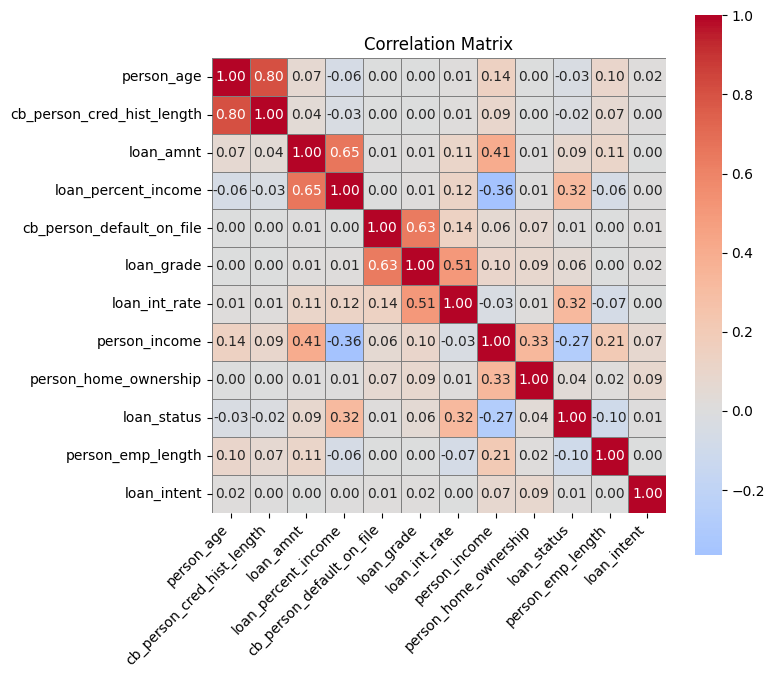

In [27]:
corr_analyzer = CorrelationAnalyzer(cleaned_df)
corr_df,corr_matrix = corr_analyzer.correlation_matrix(num_method="spearman", cat_method="cramers_v",
                                      cat_num_method="mutual_info",return_matrix=True)

Visualisation.plot_heatmap_matrix(corr_matrix, title="Correlation Matrix")

# save_utils.save_dataframe_to_csv(corr_df, os.path.join(output_path, "correlation_df.csv"), overwrite=True)


#### 4.2 Multicollinearity Detection

This section is identifying and resolving multicollinearity among numerical features in a dataset using:
- **Variance Inflation Factor (VIF)**.
- **Pairwise correlation analysis**.

In [28]:
detector = MulticollinearityDetector(cleaned_df, correlation_matrix=corr_matrix)

# VIF values
print(detector.compute_vif())

# Correlated pairs
print('High Correlation Pairs: ',detector.high_correlation_pairs())

# Suggestions for dropping features with high correlation and multicollinearity
print('Suggestion for Features to drop: ', detector.suggest_features_to_drop())

                      feature       VIF
0                  person_age  4.372233
1               person_income  1.483859
2           person_emp_length  1.068821
3                   loan_amnt  2.170838
4               loan_int_rate  1.157909
5                 loan_status  1.345880
6         loan_percent_income  2.361377
7  cb_person_cred_hist_length  4.338306
High Correlation Pairs:  []
Suggestion for Features to drop:  {'high_corr_drops': [], 'high_vif_drops': [], 'both': []}


#### 4.3 PCA and MCA Analysis
In this section, we reduce the dimensionality of our dataset using Principal Component Analysis (PCA) for numeric features and Multiple Correspondence Analysis (MCA) for categorical features. These methods help uncover latent patterns, simplify complexity, and enhance visualization by projecting high-dimensional data into lower-dimensional spaces while preserving as much variability as possible.

##### 4.3.1 PCA Analysis on Numerical Features

In this step, we perform Principal Component Analysis (PCA) to explore the structure of the numerical feature space and understand the variance explained by the principal components.

Steps:
1. **Drop non-numerical features and the target variable** to ensure PCA only processes numerical data.
2. **Fit PCA** on the cleaned numerical dataset.
3. **Plot explained variance** to decide how many components capture most of the data’s variance.
4. **Plot loadings heatmap** to understand how original features contribute to each principal component.
5. **Visualize PCA scores by target classes** to see how the target variable (e.g., loan status) is distributed in PCA space.


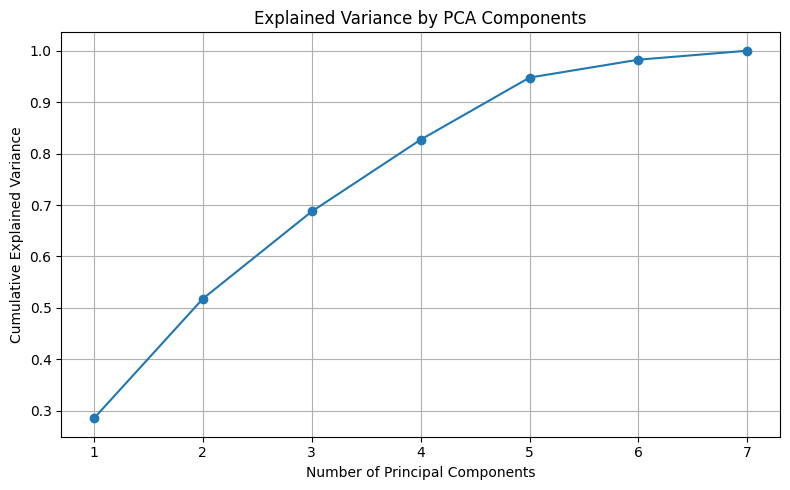

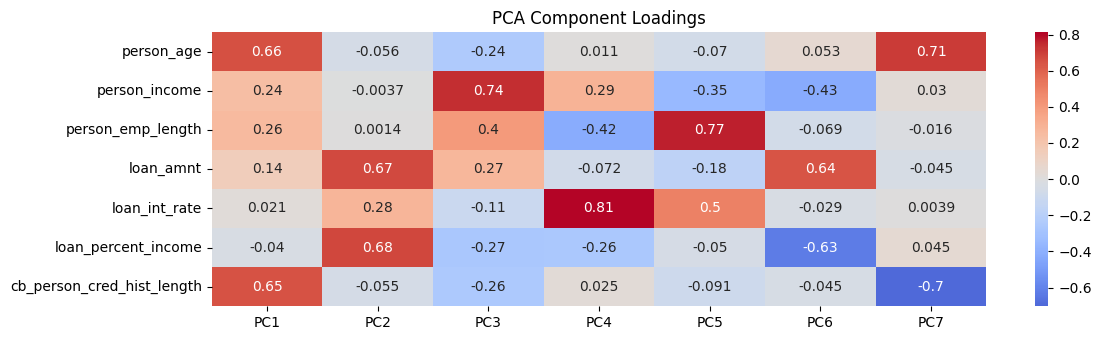

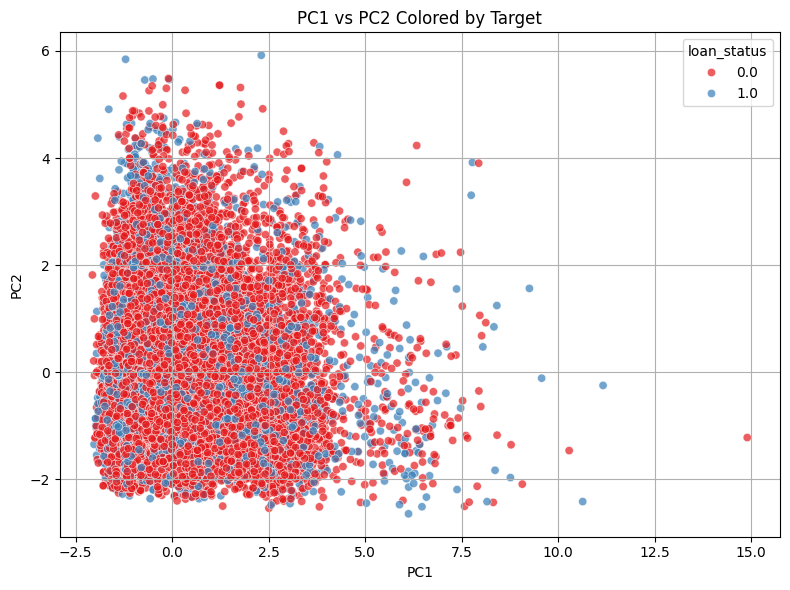

In [29]:
pca_analyzer = PCAAnalyzer()
cols_to_drop = target_variable + nominal_features + ordinal_features
num_features_df = cleaned_df.drop(columns=cols_to_drop)
pca_analyzer.fit(num_features_df)

viz = Visualisation(data=num_features_df,display_names=display_names)

# To find how many PCs are needed to capture e.g. 90–95% of the variance.
viz.plot_explained_variance(pca_analyzer.explained_variance)

# Loadings show which original features contribute to each component.
viz.plot_pca_loadings(pca_analyzer.loadings)

# Visualize target classes in PCA space
# PCA scores by target
scores_df = pca_analyzer.get_scores_df()
scores_df[target_variable[0]] = cleaned_df[target_variable[0]]  # Add target
viz.plot_pca_scores(scores_df, target_column=target_variable[0])

##### 4.3.2 MCA Analysis on Categorical Features

In this step, we perform Multiple Correspondence Analysis (MCA) to explore the structure of the categorical feature space to understand the relationships between different categories and how much "inertia" (similar to variance in PCA) is explained by the resulting dimensions.

Steps:
1. **Drop numerical features and the target variable** to ensure MCA only processes categorical data.
2. **Fit MCA** on the cleaned categorical dataset.
3. **Plot Explained Inertia** to visualize the cumulative explained inertia for the MCA dimensions.It helps in deciding how many dimensions are significant and should be retained for further analysis or interpretation
4. **Plot MCA Column Coordinates (Category Contributions)** to visualize the coordinates of the original variable categories in the reduced MCA space. It reveals associations between categories 
5. **Visualize MCA Row Coordinates (Individual Scores) by Target Class** Plot the positions (coordinates) of each individual observation (row) in the reduced dimensional MCA space. This helps in understanding if the patterns captured by MCA among categorical features are related to the outcome variable.

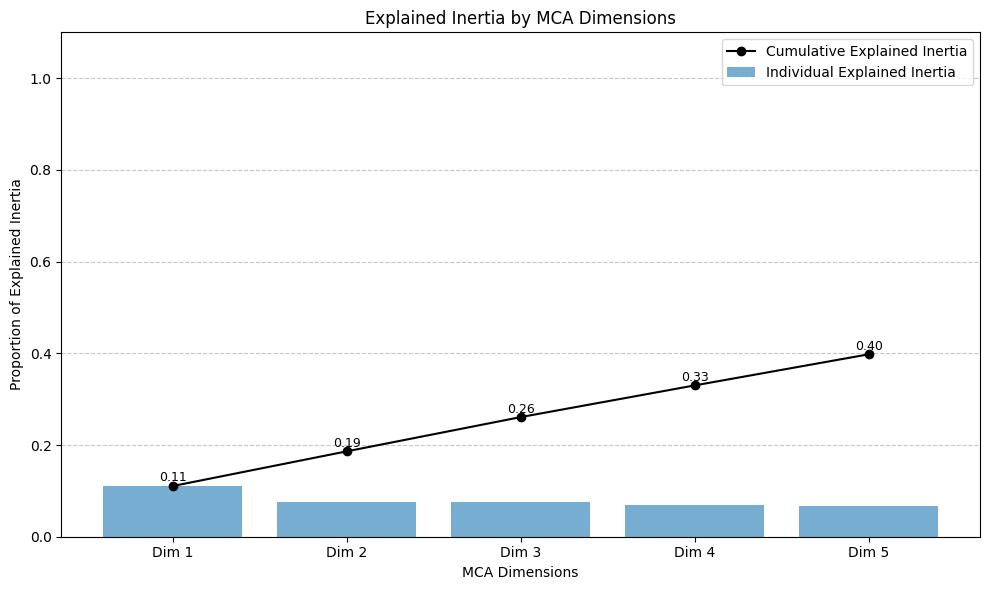

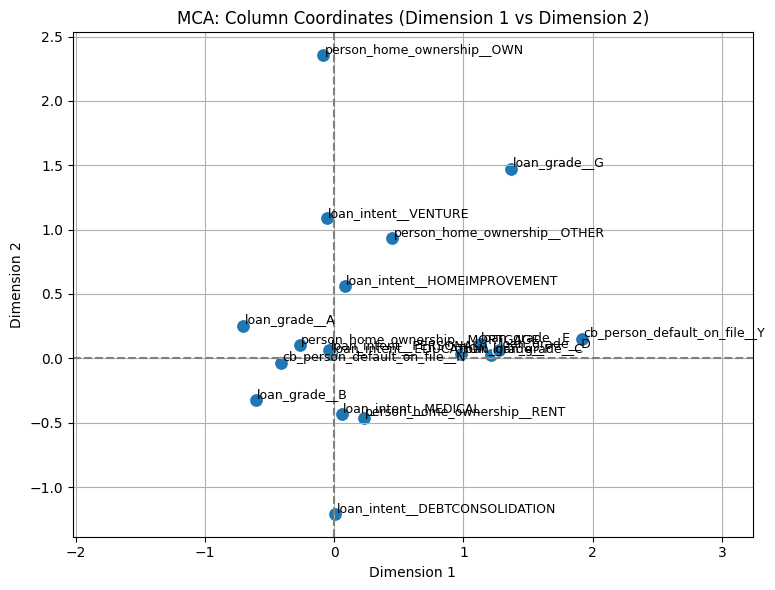

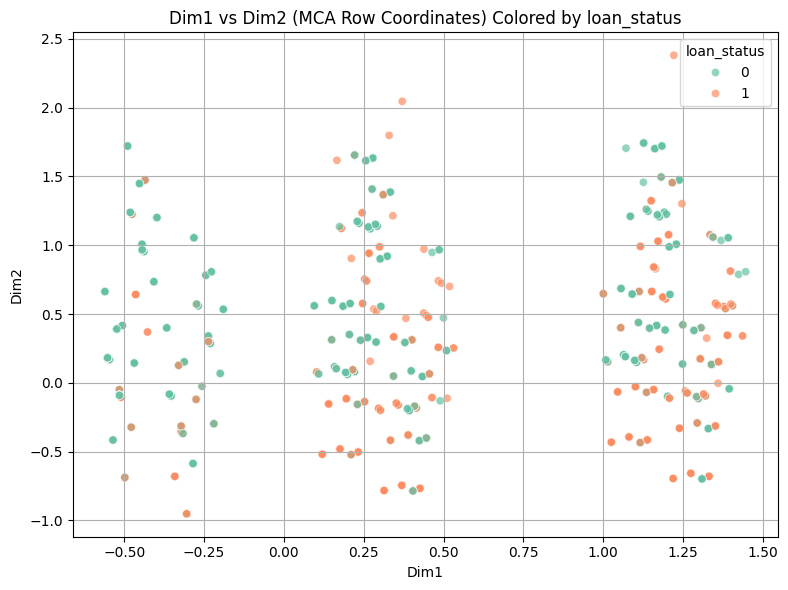

In [32]:
# MCA on categorical data
categorical_df = cleaned_df[nominal_features + ordinal_features].drop(columns=target_variable)
mca_analyzer = MCAAnalyzer(n_components=5)
mca_analyzer.fit(categorical_df)

viz = Visualisation(data=categorical_df, display_names=display_names)

# Plot explained inertia (variance) to determine how many dimensions to retain
viz.plot_mca_explained_inertia(mca_analyzer.get_explained_inertia())

# MCA column coordinates: contributions of each category to the components
viz.plot_mca_column_coordinates(mca_analyzer.get_column_coordinates_df())

# MCA results by plotting the position of each row in the reduced dimensional space, colored by the target variable.
row_coords = mca_analyzer.get_row_coordinates_df()
row_coords[target_variable[0]] = cleaned_df[target_variable[0]]
viz.plot_mca_row_coordinates(row_coords, target_column=target_variable[0])